### Classification models
##### With Departure Delay Column

In [10]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report


import xgboost as xgb

##### Load the SQL db for later comparison

In [3]:
import sqlite3
conn=sqlite3.connect("models.db")
cur=conn.cursor()

In [4]:
#Loading the dataset
df=pd.read_csv('depdelay20enc.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0'],axis=1)
df = df.sample(frac =.05).reset_index().drop(['index'], axis=1)
df.head()

,DepDelay,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,-0.414634,0.960627,2.322630,0,0.916712,-0.399549,0.592013,-0.805928,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.018217,0.030933,0.050732
1,-0.341463,0.457457,-0.010703,1,0.697790,-0.716302,-0.096714,-0.995312,0.000000e+00,1.000000,0.781831,0.623490,0.064614,0.014071,0.072968
2,1.682927,0.558559,-0.094801,1,-0.995056,0.099320,-0.809017,0.587785,5.000000e-01,-0.866025,0.433884,-0.900969,0.016379,0.014071,0.050732
3,0.390244,0.303303,-0.423547,1,0.824126,-0.566406,0.801254,-0.598325,1.224647e-16,-1.000000,0.000000,1.000000,0.018217,0.008873,0.034908
4,-0.073171,0.208709,-0.330275,1,-0.978689,-0.205350,-0.962455,0.271440,0.000000e+00,1.000000,0.433884,-0.900969,0.030147,0.003692,0.053159


##### Split Train and Test  and set ArrDelay as target column

In [5]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

##### Support Vector Classification

In [5]:
clf = svm.SVC(kernel='linear', random_state=42, gamma='auto')
scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.8403


In [6]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [7]:
cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

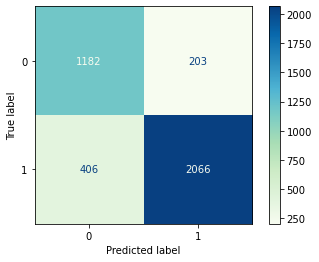

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [9]:
#Specificity = TN / (TN + FP)
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.8534
Accuracy: 0.8421
Precision: 0.9105
Recall or Sensitivity: 0.8358
F1 Score: 0.8715


In [10]:
model='sv1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### KNN K-Nearest Neighbors

In [11]:
knn = KNeighborsClassifier(n_neighbors=32)
score=cross_val_score(knn, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.7915


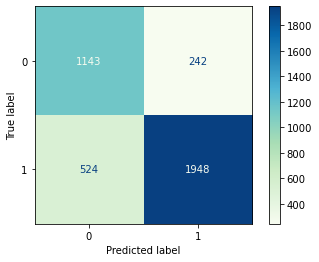

In [12]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [13]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.8253
Accuracy: 0.8014
Precision: 0.8895
Recall or Sensitivity: 0.788
F1 Score: 0.8357


In [14]:
model='knn1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### logistic regression

In [15]:
logreg = LogisticRegression(solver='liblinear')
score=cross_val_score(logreg, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.8415


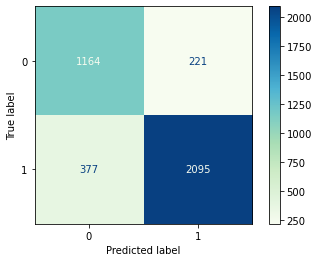

In [16]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [17]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.8404
Accuracy: 0.845
Precision: 0.9046
Recall or Sensitivity: 0.8475
F1 Score: 0.8751


In [18]:
model='lg1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### Decision Tree

In [19]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
scores=cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.8330


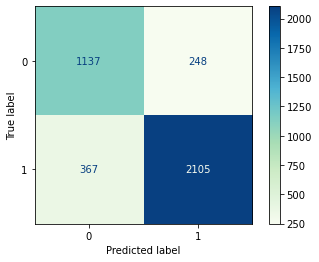

In [20]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [21]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.8209
Accuracy: 0.8405
Precision: 0.8946
Recall or Sensitivity: 0.8515
F1 Score: 0.8725


In [22]:
model='dt1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### neural network MLPClassifier

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5), max_iter=50, activation = 'relu',solver='adam',random_state=42)
score=cross_val_score(mlp, X, y, cv=StratifiedKFold(n_splits=10), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.8425


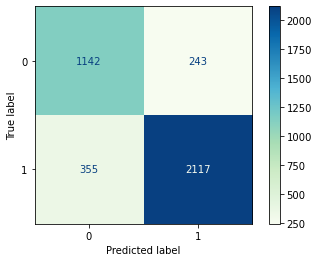

In [24]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [25]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.8245
Accuracy: 0.845
Precision: 0.897
Recall or Sensitivity: 0.8564
F1 Score: 0.8762


In [26]:
model='nn1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Naive Bayes

In [27]:
clf = GaussianNB()
score=cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.8010


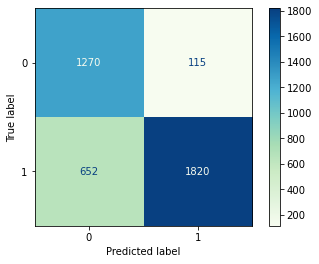

In [28]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='GnBu') 

In [29]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.917
Accuracy: 0.8011
Precision: 0.9406
Recall or Sensitivity: 0.7362
F1 Score: 0.826


In [30]:
model='nb1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()



##### Ada Boost Classifier

In [32]:
ada = AdaBoostClassifier(n_estimators=12, random_state=42,algorithm='SAMME')
score=cross_val_score(ada, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.8305


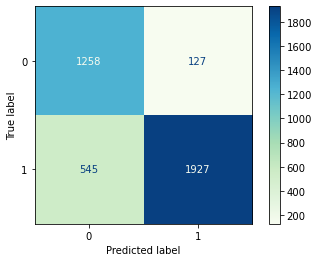

In [33]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='GnBu') 

In [34]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.9083
Accuracy: 0.8258
Precision: 0.9382
Recall or Sensitivity: 0.7795
F1 Score: 0.8515


In [35]:
model='ada1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### xgboost

In [12]:
xg_reg = xgb.XGBClassifier(objective="reg:squarederror", booster="gblinear", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 0)
scores = cross_val_score(xg_reg, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
scores

0.643020127224629

In [14]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

acc = metrics.accuracy_score(y_test, preds)
print("Accuracy: %f" % (acc))

Accuracy: 0.725175


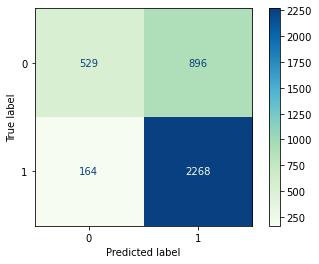

In [15]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='GnBu') 

In [16]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.3712
Accuracy: 0.7252
Precision: 0.7168
Recall or Sensitivity: 0.9326
F1 Score: 0.8106


In [17]:
model='xgb1'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()